In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

from keras.models import Sequential
from keras.layers import Flatten, Dense

Deze opdracht gaat over het herkennen van gesproken commando's met deep learning.

We maken gebruik van een subset van de data uit de Tensorflow Speech Recognition Challenge: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data

Download de file train.7z en sla de uitgepakte bestanden op in de zelfde map als dit bestand (dan kloppen onderstaande paden).

In [3]:
dir = ''

train_dir = os.path.join(dir, 'train/audio')
test_dir = os.path.join(dir, 'test/audio')

# Visualiseer de data

Laten we eerst eens naar een enkel bestand kijken waarin het woord 'cat' wordt uitgesproken.

In [4]:
example_filename = os.path.join(train_dir, 'cat/00b01445_nohash_0.wav')

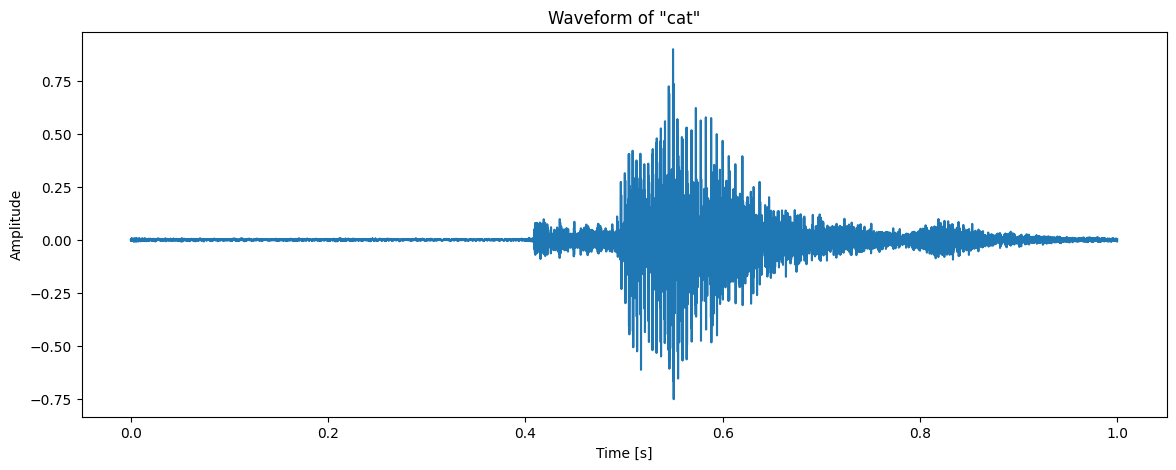

In [5]:
samples_cat, sample_rate = librosa.load(example_filename)

plt.figure(figsize=(14, 5))
plt.plot(np.arange(len(samples_cat)) / sample_rate, samples_cat)
plt.title('Waveform of "cat"')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

In [6]:
len(samples_cat)

22050

Ter vergelijking bekijken we een opname van het woord 'dog'.

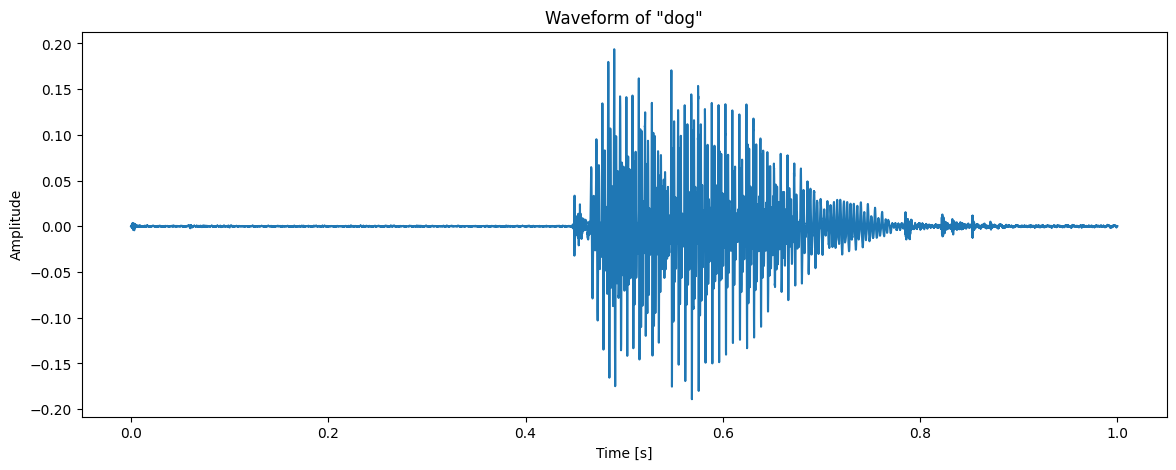

In [7]:
example_filename = os.path.join(train_dir, 'dog/0a7c2a8d_nohash_0.wav')

samples_dog, sample_rate = librosa.load(example_filename)

plt.figure(figsize=(14, 5))
plt.plot(np.arange(len(samples_dog)) / sample_rate, samples_dog)
plt.title('Waveform of "dog"')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

## Spectrum

We plotten de frequenties in een klein stuk van de opname van 'cat'.

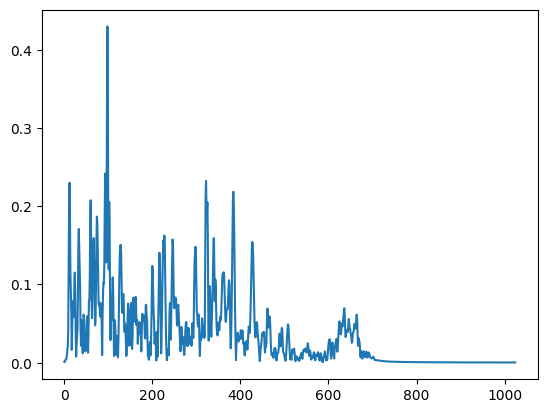

In [8]:
n_fft = 2048
plt.plot(np.abs(librosa.stft(samples_cat[:n_fft], n_fft=n_fft, hop_length = n_fft + 1)))

## Spectogram

Een spectogram laat de geluidsintensiteit op verschillende frequenties uitgezet in de tijd zien.

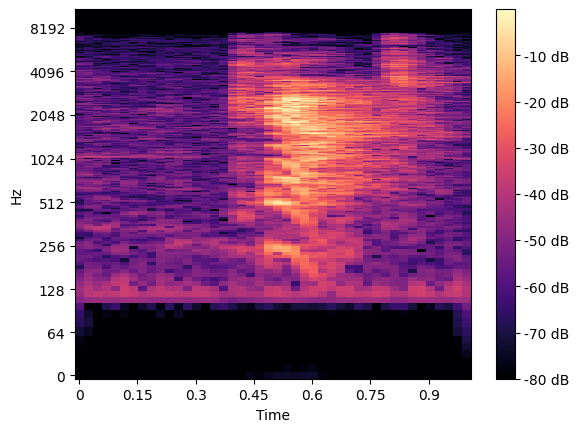

In [9]:
#cat

hop_length = 512

stft = np.abs(librosa.stft(samples_cat, n_fft = n_fft, hop_length = hop_length))
DB = librosa.amplitude_to_db(stft, ref=np.max)

librosa.display.specshow(DB, sr = sample_rate, x_axis = 'time', y_axis = 'log')
plt.colorbar(format='%+2.0f dB')

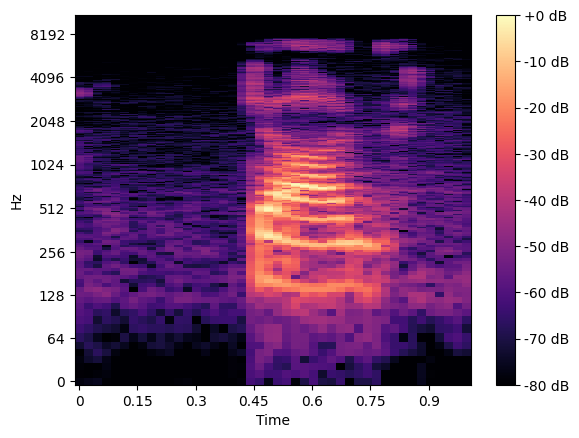

In [10]:
#dog

stft = np.abs(librosa.stft(samples_dog, n_fft = n_fft, hop_length = hop_length))
DB = librosa.amplitude_to_db(stft, ref=np.max)

librosa.display.specshow(DB, sr = sample_rate, x_axis = 'time', y_axis = 'log')
plt.colorbar(format='%+2.0f dB')

## MFCC

MFCC features proberen de belangrijkste informatie in een spraaksignaal te representeren.

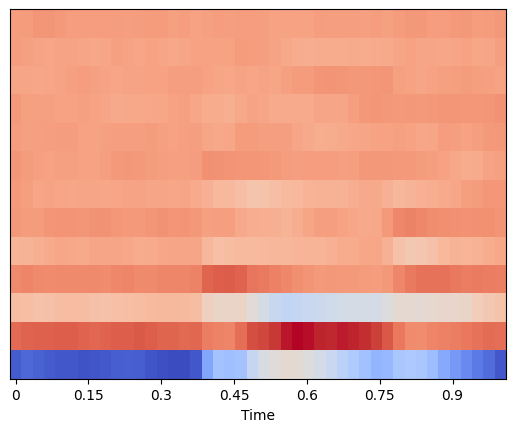

In [11]:
mfccs = librosa.feature.mfcc(y=samples_cat, sr = sample_rate, n_mfcc = 13)
librosa.display.specshow(mfccs, x_axis='time')

# Herkennen van woorden

We kunnen de MFCC representatie gebruiken als input voor een deep learning model. We gaan proberen om een aantal verschillend woorden te herkennen met behulp van een LSTM. 

Je kunt eventueel meer labels toevoegen (namen van de mappen in de dataset).

In [12]:
labels = ['cat', 'dog', 'yes', 'no']

## Prepareer de data

We zetten alle opnamen van de betreffende woorden om in MFCC features. We kiezen hier voor 13 MFCC features die we elke 10 ms berekenen voor een stukje van 25 ms van het spraaksignaal.

In [13]:
X_train = []
y_train = []

max_len = 80 # om ons model iets te vereenvoudingen gebruiken we een vaste lengte voor de inputs


for label in labels:
    wav_dir = os.path.join(train_dir, label)
    waves = [f for f in os.listdir(wav_dir) if f.endswith('.wav')]
    
    for wav in waves:
        samples, sample_rate = librosa.load(os.path.join(wav_dir, wav), sr = 16000)
        mfccs = librosa.feature.mfcc(y= samples, sr = sample_rate, n_mfcc = 13, hop_length=int(sample_rate/100), n_fft=int(sample_rate/40))
        
        if (mfccs.shape[1] > max_len): # sla opnamen die te kort zijn over
            mfccs = mfccs[:, :max_len]
        
            X_train.append(mfccs)
            y_train.append(label)

We brengen X_train en y_train in de juiste vorm om gebruikt te worden door `keras` modellen.

In [14]:
X_train = np.array(X_train)
X_train = np.swapaxes(X_train, 1, 2)
X_train.shape

(7952, 80, 13)

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(np.array(y_train))

y_train = to_categorical(y_train)

y_train[0:3]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [17]:
X_train.shape

(6361, 80, 13)

In [18]:
y_train.shape

(6361, 4)

## Selecteer een model, train, verbeter, evalueer

Experimenteer met geschikte Deep Learning modellen. Welk model werkt het beste?

Tip 1: de input heeft de vorm: `input_shape = (80, 13)`.

Tip 2: Dropout kan helpen.

In [19]:
from keras.layers import Dropout, LSTM

# Model
input_shape = (X_train.shape[1], X_train.shape[2]) # (80, 13)

model = Sequential([
    LSTM(128, input_shape=input_shape, return_sequences=True),
    Dropout(0.5),
    LSTM(128),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 128)           72704     
                                                                 
 dropout (Dropout)           (None, 80, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 204804 (800.02 KB)
Trainable params: 204804 (800.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# training
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
199/199 [==============================] - 12s 59ms/step - loss: 0.4139 - accuracy: 0.8577 - val_loss: 0.3532 - val_accuracy: 0.8718
Epoch 2/10
199/199 [==============================] - 11s 57ms/step - loss: 0.3302 - accuracy: 0.8857 - val_loss: 0.2689 - val_accuracy: 0.9095
Epoch 3/10
199/199 [==============================] - 11s 58ms/step - loss: 0.2886 - accuracy: 0.9000 - val_loss: 0.2550 - val_accuracy: 0.9038
Epoch 4/10
199/199 [==============================] - 11s 57ms/step - loss: 0.2488 - accuracy: 0.9126 - val_loss: 0.2436 - val_accuracy: 0.9082
Epoch 5/10
199/199 [==============================] - 11s 57ms/step - loss: 0.2360 - accuracy: 0.9190 - val_loss: 0.2177 - val_accuracy: 0.9239
Epoch 6/10
199/199 [==============================] - 12s 58ms/step - loss: 0.2222 - accuracy: 0.9203 - val_loss: 0.1932 - val_accuracy: 0.9252
Epoch 7/10
199/199 [==============================] - 12s 58ms/step - loss: 0.1899 - accuracy: 0.9319 - val_loss: 0.1701 - val_accuracy:

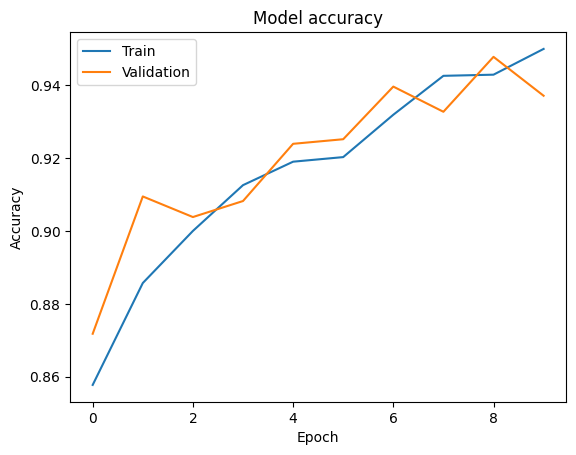

In [22]:
# plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Zijn er woorden die de modellen vaak door elkaar halen?

50/50 [==============================] - 2s 21ms/step


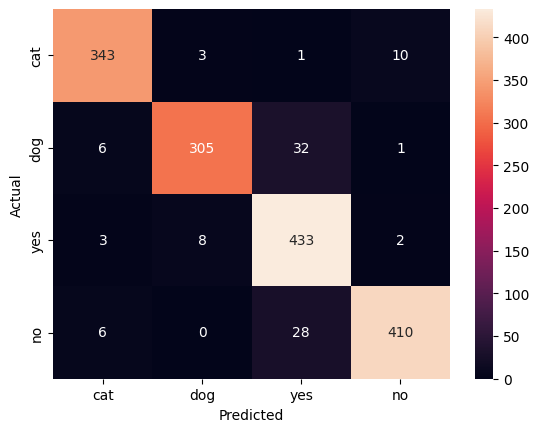

In [23]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_val, axis=1)

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Hier maakt het model het meest de fout met het woord 'yes'.
- 32 keer voorspelde het model 'yes' terwijl het 'dog' was. Anders om maakt hij die fout bijan niet.
- 28 keer voorspelde het model 'yes' terwijl het 'no' was. Alweer, andersom maakt hij deze fout niet.


Bonusvraag: Hierboven hebben we plaatjes gemaakt van de data. We zouden deze afbeeldingen als input kunnen beschouwen. We zien iedere input dan dus als een twee-dimensionale afbeelding en kunnen deze classificeren met modellen voor beeldherkenning. Maak zo'n model.

Het is dan wel nodig om de vorm van `X_train` en `X_val` zo aan te passen dat deze een 'kleuren kanaal' hebben. Je kunt dit op de MFCC features doen, maar ook op een spectogram. gebruik hiervoor `librosa.melspectogram`.